In [ ]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

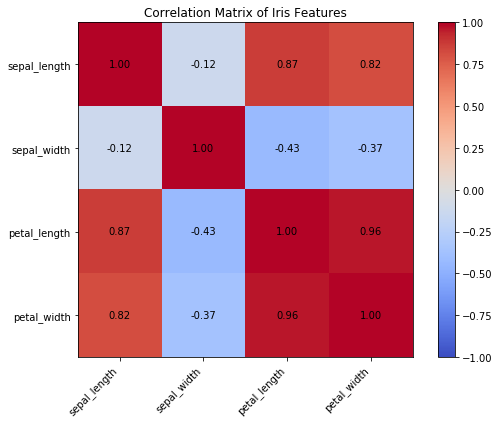

In [49]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')
iris = sns.load_dataset('iris')

# 라인 플롯을 위한 시계열 데이터 생성
time_series = pd.DataFrame({
    'date': pd.to_datetime(pd.date_range('2023-01-01', periods=12, freq='M')),
    'sales': np.random.randint(100, 500, size=12)
})

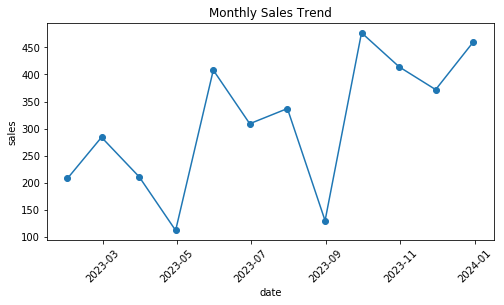

In [8]:
plt.figure(figsize=(8, 4))

# seaborn으로 작성 시
# sns.lineplot(x='date', y='sales', data=time_series, marker='o')

# seaborn 없이 작성 시 x, y 축 명칭 작성해야함
plt.plot(time_series['date'], time_series['sales'], marker='o')
plt.xlabel('date')
plt.ylabel('sales')

plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.show()

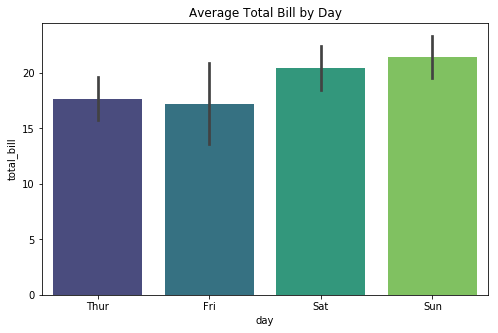

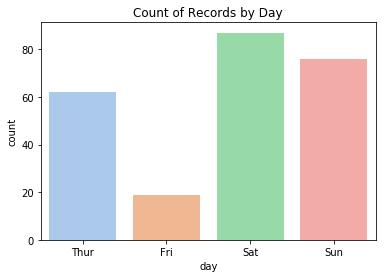

In [10]:
plt.figure(figsize=(8, 5))
# barplot은 기본적으로 각 범주에 대한 평균값(추정치)과 신뢰구간을 보여줌
sns.barplot(x='day', y='total_bill', data=tips, palette='viridis')
plt.title('Average Total Bill by Day')
plt.show()

# 단순히 빈도를 세고 싶을 때는 countplot 사용
sns.countplot(x='day', data=tips, palette='pastel')
plt.title('Count of Records by Day')
plt.show()

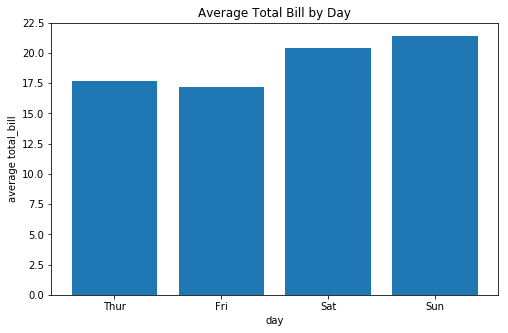

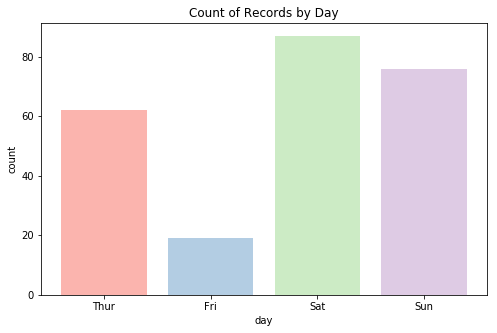

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# day별 평균 total_bill 계산
mean_values = tips.groupby('day')['total_bill'].mean()

plt.bar(mean_values.index, mean_values.values)
plt.title('Average Total Bill by Day')
plt.xlabel('day')
plt.ylabel('total_bill')
plt.show()

# day별 빈도 계산
count_values = tips['day'].value_counts().sort_index()

plt.bar(count_values.index, count_values.values, color=plt.cm.Pastel1(range(len(count_values))))
plt.title('Count of Records by Day')
plt.xlabel('day')
plt.ylabel('count')
plt.show()

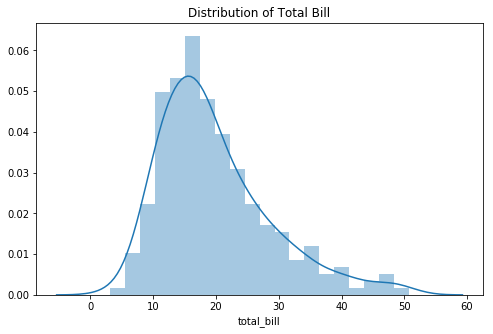

In [16]:
plt.figure(figsize=(8, 5))
sns.distplot(tips['total_bill'], bins=20, kde=True)  # hist + kde
plt.title('Distribution of Total Bill')
plt.show()

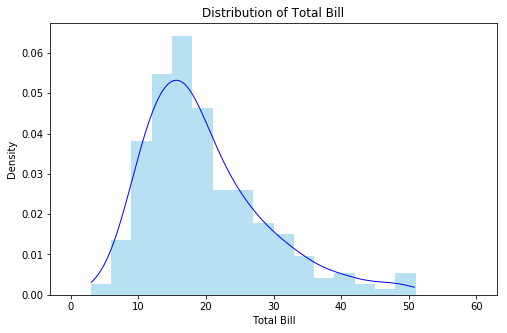

In [34]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(8, 5))

# (1) 히스토그램 (edgecolor 추가 시 막대에 테두리 생성)
plt.hist(tips['total_bill'], bins=20, density=True, alpha=0.6, color='skyblue', range=(0, 60))#, edgecolor='black')

# (2) KDE (밀도 추정 곡선)
kde = gaussian_kde(tips['total_bill'])  # 데이터 기반 KDE 모델 생성
x = np.linspace(tips['total_bill'].min(), tips['total_bill'].max(), 200)  # 구간 생성
plt.plot(x, kde(x), color='b', linewidth=1)

# (3) 제목
plt.title('Distribution of Total Bill')
plt.xlabel('Total Bill')
plt.ylabel('Density')

plt.show()

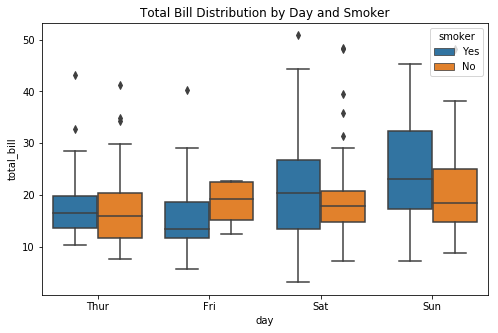

In [25]:
plt.figure(figsize=(8, 5))
# hue를 통해 각 값을 추가로 분리해서 그릴 수 있다.
sns.boxplot(x='day', y='total_bill', hue='smoker', data=tips)
plt.title('Total Bill Distribution by Day and Smoker')
plt.show()

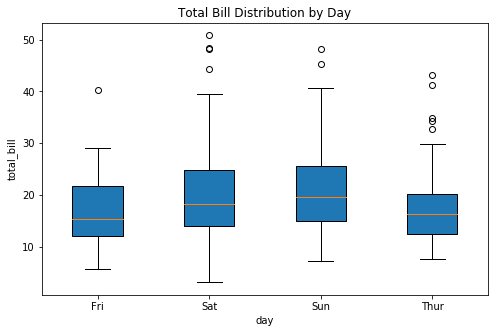

In [28]:
plt.figure(figsize=(8, 5))

# day별 total_bill 값 모아주기
data_to_plot = [tips[tips['day'] == day]['total_bill'] for day in sorted(tips['day'].unique())]

# 박스플롯 그리기
plt.boxplot(data_to_plot, labels=sorted(tips['day'].unique()), patch_artist=True)

plt.xlabel("day")
plt.ylabel("total_bill")
plt.title("Total Bill Distribution by Day")
plt.show()

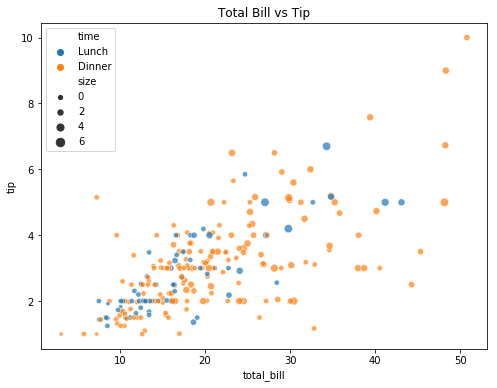

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_bill', y='tip', hue='time', size='size', data=tips, alpha=0.7)
plt.title('Total Bill vs Tip')
plt.show()

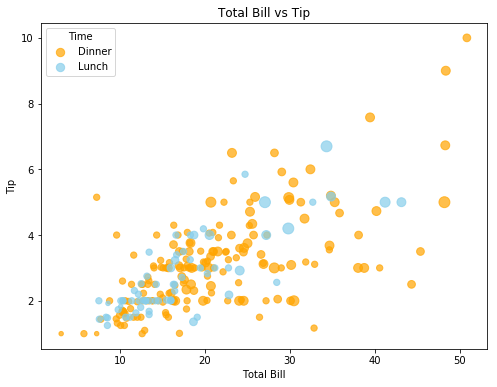

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 색상을 time에 따라 다르게 지정
colors = {'Lunch': 'skyblue', 'Dinner': 'orange'}

# 산점도 직접 반복해서 그리기
for time in tips['time'].unique():
    subset = tips[tips['time'] == time]
    plt.scatter(
        subset['total_bill'],
        subset['tip'],
        s=subset['size'] * 20,   # size 열을 마커 크기로 반영 (배율 조정)
        alpha=0.7,
        label=time,
        color=colors[time]
    )

plt.xlabel("Total Bill")
plt.ylabel("Tip")
plt.title("Total Bill vs Tip")

plt.legend(title="Time")
plt.show()

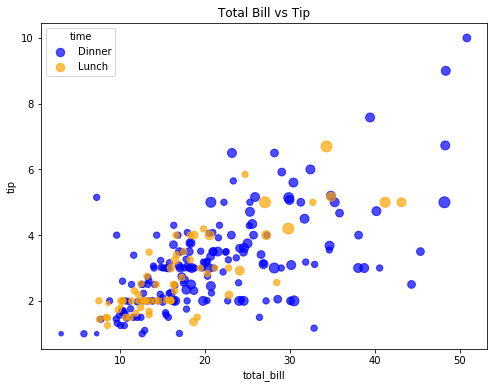

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# time 컬럼의 고유값에 따라 색상 지정
colors = {'Lunch': 'orange', 'Dinner': 'blue'}

for time_value in tips['time'].unique():
    subset = tips[tips['time'] == time_value]
    plt.scatter(
        subset['total_bill'],
        subset['tip'],
        s=subset['size'] * 20,   # size에 비례해서 점 크기 조절
        c=colors[time_value],
        alpha=0.7,
        label=time_value
    )

plt.xlabel("total_bill")
plt.ylabel("tip")
plt.title("Total Bill vs Tip")
plt.legend(title="time")
plt.show()


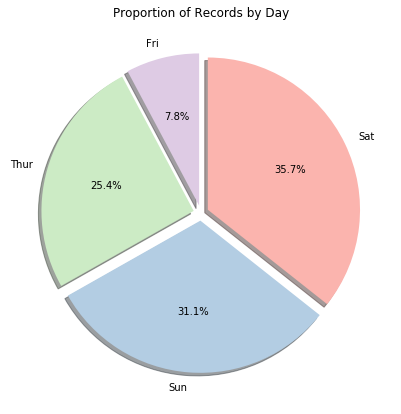

In [48]:
plt.figure(figsize=(7, 7))

# day별 빈도 계산
day_counts = tips['day'].value_counts()

# 파이 차트 그리기
plt.pie(
    day_counts.values, 
    labels=day_counts.index, 
    autopct='%1.1f%%',   # 각 조각의 비율 표시
    startangle=90,       # 12시 방향에서 시작
    counterclock=False,  # 시계 방향으로 회전
    shadow=True,         # 그림자 추가
    explode = [0.05, 0.05, 0.05, 0.05], # 중심으로 부터 1,2,3 을 얼마만큼 띄울지
    colors=plt.cm.Pastel1(range(len(day_counts)))  # 색상 지정
)

plt.title('Proportion of Records by Day')
plt.show()

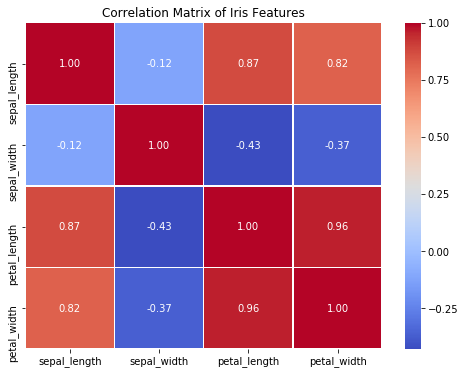

In [33]:
# iris 데이터의 수치형 변수 간 상관계수 계산
corr = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Iris Features')
plt.show()

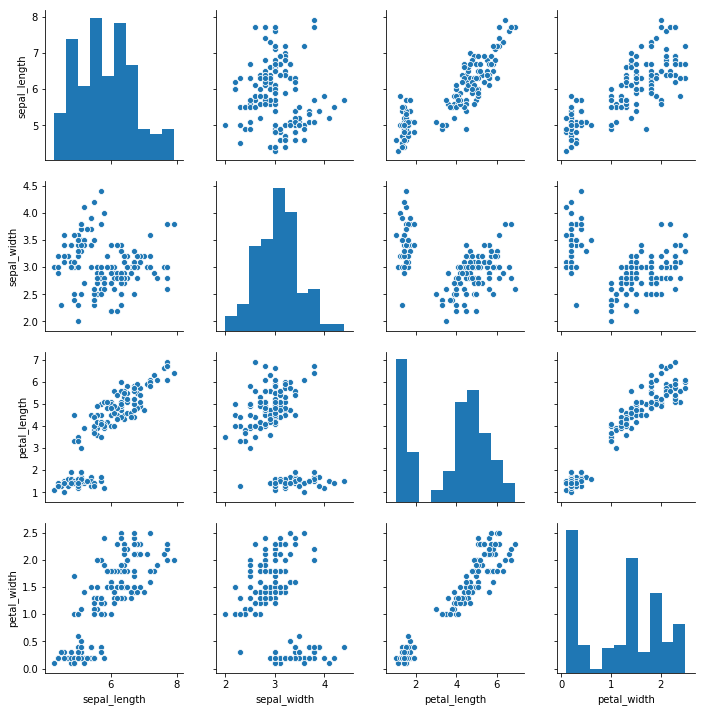

In [52]:
sns.pairplot(iris)
plt.show()

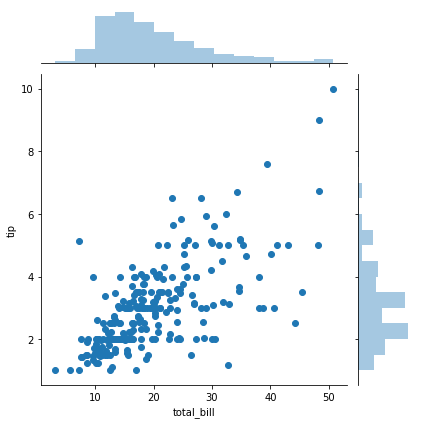

In [42]:
sns.jointplot(x='total_bill', y='tip', data=tips)
plt.show()

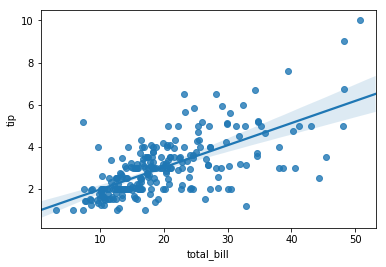

In [44]:
sns.regplot(x='total_bill', y='tip', data=tips)
plt.show()

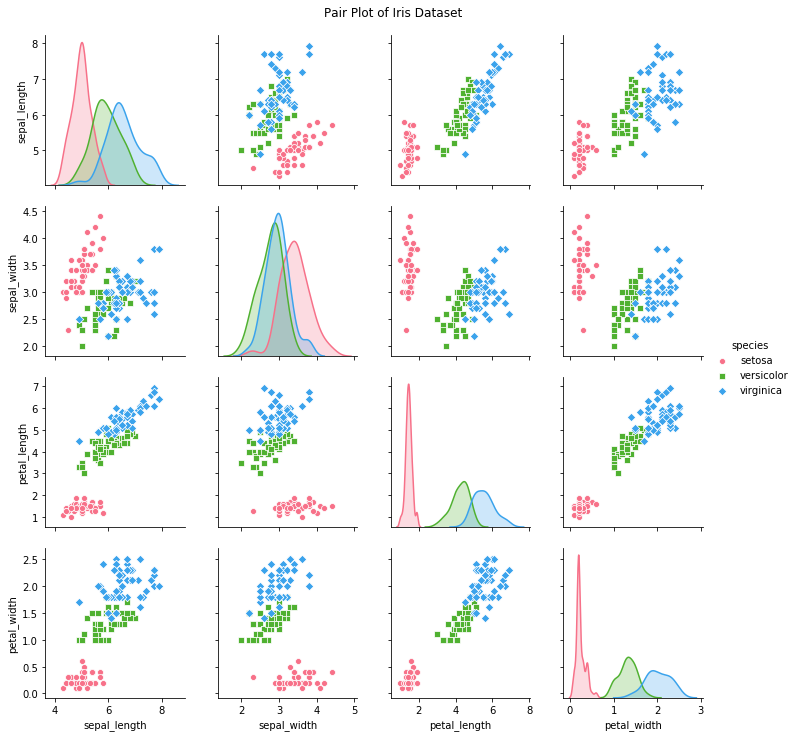

In [50]:
# hue='species'를 통해 품종별로 색상을 다르게 표시
sns.pairplot(iris, hue='species', palette='husl', markers=['o', 's', 'D'])
plt.suptitle('Pair Plot of Iris Dataset', y=1.02)
plt.show()